Redshift: 8.36568181818
	T_int: 3857.31103516
	Nbls: 51
	Ngps: 5
	Ndays: 34.1105071676
	Nlstbins: 8.0
Tsys =  422309.456191
Nseps =  1
capo.sensitivity Pk_noise =  4436767.36822
Comparison of Values:
[ 171.34781806   22.95869529    9.30483671    1.65157287   13.60967673
    4.28530842    0.73928839    2.42633722    2.36266338    4.97775824
    0.97467621]
Mean ratio: 21.3307846848
Median ratio: 4.28530841858
Mean ratio (k>.1): 4.48134646426
Median ratio (k>.1): 2.42633722358


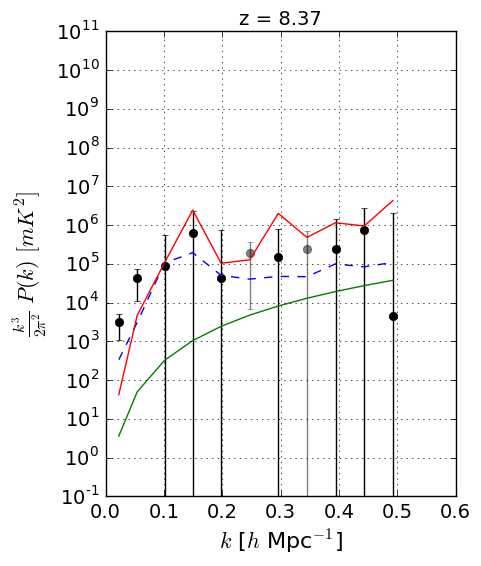

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import capo
from capo.cosmo_units import f212z
from capo import sensitivity

# Method #1 File
dist_file = '/data4/paper/ctc/PSA64/PAPER_METHODS/PSA64_FRF_RA.5_8.6_CHAN95_115_SEP0,1_INVERSECOVWEIGHT_WEIGHTI/pspec_final_sep0,1.npz'

# Method #2 File
confidence_file = '/data4/paper/ctc/PSA64/PAPER_METHODS/PSA64_FRF_RA.5_8.6_CHAN95_115_SEP0,1_INVERSECOVWEIGHT_WEIGHTI/pspec_final_confidence_90.npz'

# Load files
dist_data = np.load(dist_file)
conf_data = np.load(confidence_file)

# Sensitivity Stuff
redshift = f212z(dist_data['freq'] * 1e9)
inttime = dist_data['frf_inttime']
cnt = dist_data['cnt_eff']
nbls_g = dist_data['nbls_g']
nlsts = len(dist_data['lsts']) * dist_data['inttime']
nlsts /= dist_data['frf_inttime']
nlsts_g = dist_data['nlsts_g']
if dist_data['frf_inttime'] == dist_data['inttime']:
    omega_eff = .74**2/.32 # for capo analytical; from T1 of Parsons FRF paper
else:
    omega_eff = .74**2/.24
print 'Redshift:', redshift
print '\tT_int:', inttime
print '\tNbls:', dist_data['nbls']
print '\tNgps:', dist_data['ngps']
print '\tNdays:', cnt
print '\tNlstbins:', nlsts_g
S = sensitivity.Sense()
f = dist_data['freq']
S.z = capo.pspec.f2z(f)
S.Tsys = (144 + 180.*(f/.180)**-2.55)*1e3 #set to match noise realization
print "Tsys = ",S.Tsys

S.t_int = inttime
S.Ndays = cnt  #effective number of days
S.Npols = 2
try: S.Nseps = dist_data['nseps']
except: S.Nseps = 1
print "Nseps = ",S.Nseps
S.Nblgroups = dist_data['ngps'] 
S.Omega_eff = omega_eff #use the FRF weighted beams listed in T1 of Parsons etal beam sculpting paper
k = dist_data['k']
S.Nbls = dist_data['nbls']
S.Nlstbins = nlsts_g
S.calc()
print "capo.sensitivity Pk_noise = ",S.P_N

# PS Values
dist_ks = dist_data['k']
fold_factor = dist_data['k']**3/(2*np.pi**2)
dist_pCv_fold = dist_data['pCv_fold']*fold_factor
dist_pIv_fold = dist_data['pIv_fold']*fold_factor
dist_pCv_fold_up = dist_data['pCv_fold_err']*2*fold_factor
dist_pIv_fold_up = dist_data['pIv_fold_err']*2*fold_factor
dist_prob = 95

pos_ind_fold = np.where(dist_pCv_fold >= 0)[0]
neg_ind_fold = np.where(dist_pCv_fold < 0)[0]

conf_ks = conf_data['k']
conf_pCv_fold = conf_data['pC_fold']
conf_pIv_fold = conf_data['pI_fold']
conf_pCv_fold_up = conf_data['pC_fold_up']
conf_pIv_fold_up = conf_data['pI_fold_up']
conf_prob = 95

print 'Comparison of Values:'
dist_uplims= np.abs(dist_pCv_fold) + 2*dist_pCv_fold_up
conf_uplims = np.abs(conf_pCv_fold) + conf_pCv_fold_up
ratio = dist_uplims/conf_uplims
print ratio
print "Mean ratio:", np.nanmean(ratio)
print "Median ratio:", np.nanmedian(ratio)
print "Mean ratio (k>.1):", np.mean(ratio[2:])
print "Median ratio (k>.1):", np.median(ratio[2:])

# Plotting
fig, ax = plt.subplots(1, figsize=(5,6))
ymax=1e11
ax.set_yscale('log', noposy='clip')
ax.set_ylim([1e-1,ymax])
ax.set_xlim([0,.6])
ytick= np.power(10., np.arange(-1,np.log10(ymax)+1))
ax.set_yticks(ytick)
ax.grid()
ax.errorbar(dist_ks[pos_ind_fold], dist_pCv_fold[pos_ind_fold], dist_pCv_fold_up[pos_ind_fold],
            fmt='ko', label='', capsize=2)
ax.errorbar(dist_ks[neg_ind_fold], -1*dist_pCv_fold[neg_ind_fold], dist_pCv_fold_up[neg_ind_fold],
            fmt='ko',alpha=.5, capsize=2)
ax.plot(dist_ks, np.abs(dist_pIv_fold) + dist_pIv_fold_up, 'b--')
ax.plot(dist_ks, S.Delta2_N(dist_ks)*2, 'g-')

ax.plot(conf_ks, np.abs(conf_pCv_fold) + conf_pCv_fold_up, 'r-')

ax.set_title('z = {0:.2f}'.format(redshift), fontsize=14)
ax.set_ylabel('$\\frac{k^{3}}{2\pi^{2}}$ $P(k)$ $[mK^{2}]$', fontsize=16)
ax.set_xlabel('$k$ [$h$ Mpc$^{-1}$]', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

fig.subplots_adjust(left=.2)
plt.show() # Save manually as "sigloss_method_comparison_95.png"